In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyhacores.utils import *
from pyha import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']

# Application

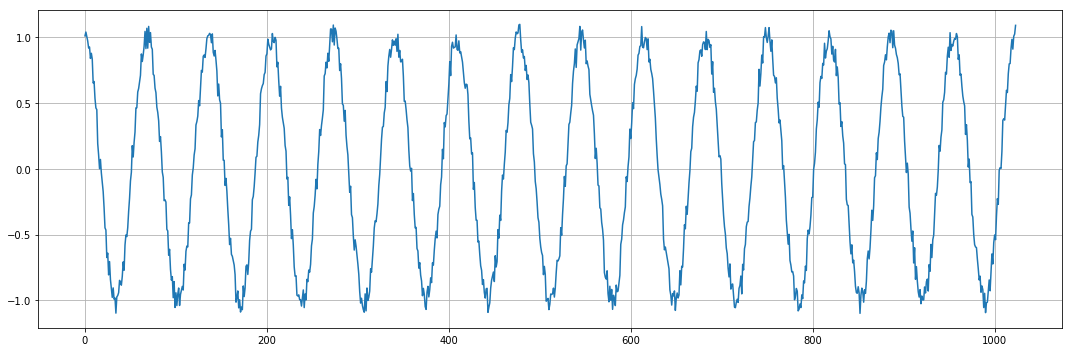

In [24]:
from pyhacores.fft import Windower
from pyhacores.fft.packager import DataWithIndex, Packager, unpackage, package
from scipy.fftpack import fft, fftshift

fft_size = 128
samples = 1024
freq = 15
sine = np.exp(2j*np.pi*np.linspace(0, 1, samples)*freq)
# input_signal = [1.0 + 1.0j] * 512 # this input signal basically just returns the window taps
noise = np.random.uniform(-1, 1, samples) + np.random.uniform(-1, 1, samples) * 1j
sine += noise * 0.1
# N = 256
# input_signal = np.reshape(input_signal, (-1, N))
plt.plot(sine)
show_plot()

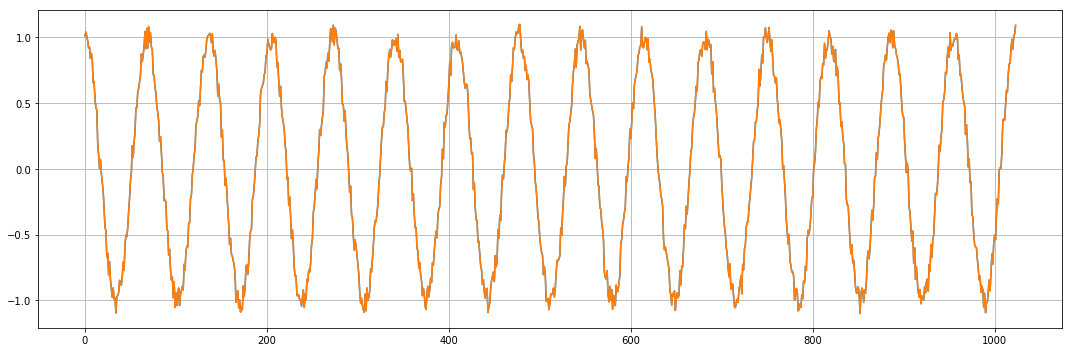

In [28]:
rev = np.fft.ifft(np.fft.fft(sine))
plt.plot(rev)
show_plot()

## Boxcar (no window)

In [4]:
dut = Windower(N, window='boxcar', coefficient_bits=9)
sims = simulate(dut, input_signal, output_callback=unpackage, input_callback=package, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 513/513 [00:00<00:00, 7196.95it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


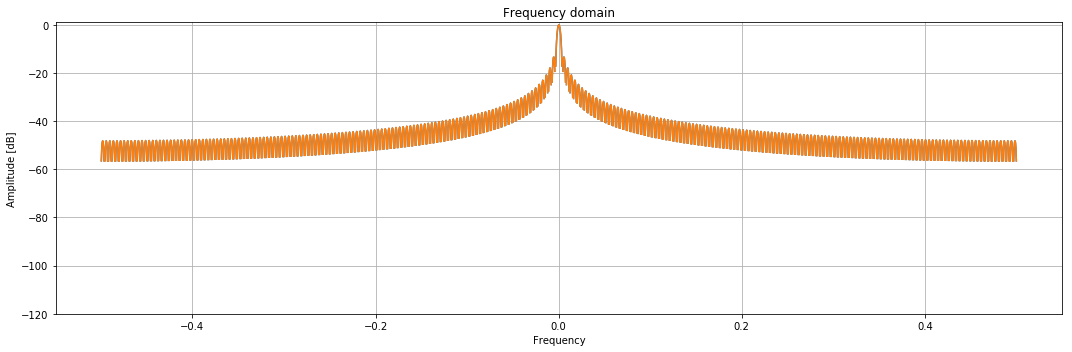

In [5]:
plt.title('Frequency domain')
for key, value in sims.items():
    plt.plot(*make_fft(value[0]))

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
plt.ylim([-120, 1])
show_plot()

## Hanning

In [6]:
dut = Windower(N, window='hanning', coefficient_bits=9)
sims = simulate(dut, input_signal, output_callback=unpackage, input_callback=package, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 513/513 [00:00<00:00, 6737.85it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


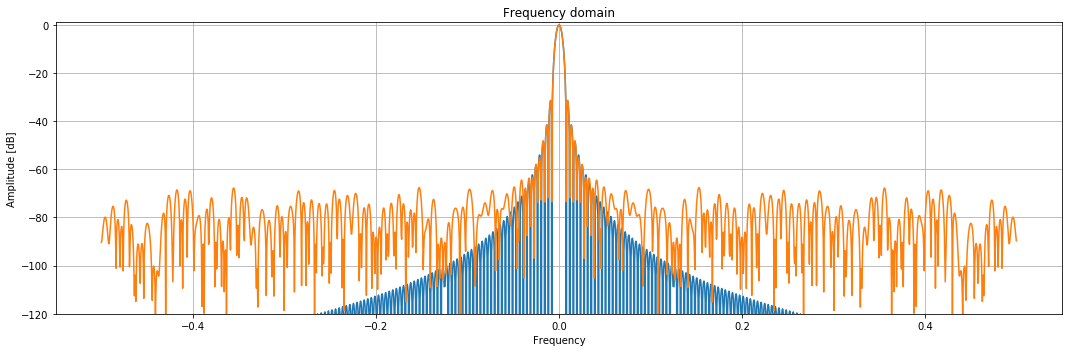

In [7]:
plt.title('Frequency domain')
for key, value in sims.items():
    plt.plot(*make_fft(value[0]))

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
plt.ylim([-120, 1])
show_plot()

## Hamming

In [8]:
dut = Windower(N, window='hamming', coefficient_bits=9)
sims = simulate(dut, input_signal, output_callback=unpackage, input_callback=package, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 513/513 [00:00<00:00, 7257.05it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


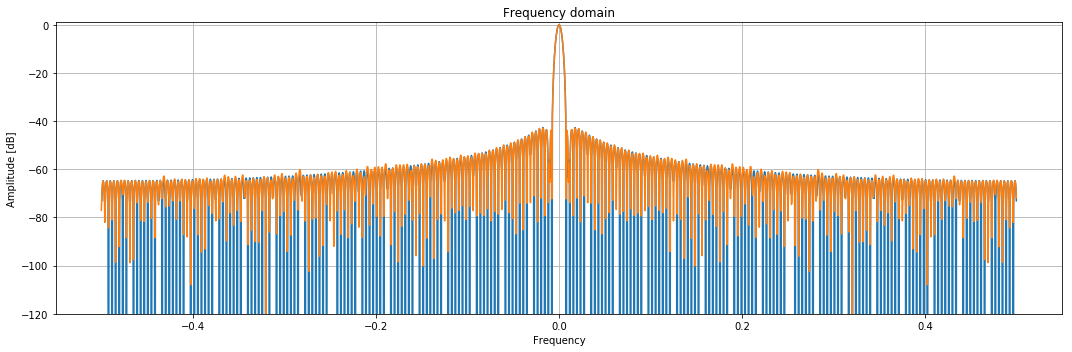

In [9]:
plt.title('Frequency domain')
for key, value in sims.items():
    plt.plot(*make_fft(value[0]))

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
plt.ylim([-120, 1])
show_plot()

# Limitations

## Fixed-point
Expects standard FPGA Fixed point format i.e 18 bits (incl. sign) and scaled to -1...1 range.

In [10]:
print(f'Minimum number representabe: {2**-17}')

Minimum number representabe: 7.62939453125e-06


## Coefficients are stored in LUTs (as constants)
Storing 18bit coefficnets for large FFT can take huge amounts of LUTS. I recommend using bitwidth of ~8, then synthsis tool can compress most of them.

# Synthesis
Resource usage depends heavily on filter taps. For example, 64 tap halfband filter needs only 16 multipliers (18bit). Complex signal needs 2 filters, so in total we could expect 32 multipliers (18bit).

In [11]:
# NBVAL_IGNORE_OUTPUT
c = convertToVHDL(dut, '/tmp/pyha_output')
_ = c.make_quartus_netlist()

INFO:conversion:Creating top.vhd ...
INFO:conversion:DataWithIndex to VHDL ...
INFO:conversion:Windower to VHDL ...
INFO:sim:Running quartus map...will take time.
INFO:sim:Analysis & Synthesis Status : Successful - Fri Aug  3 19:07:17 2018
INFO:sim:Quartus Prime Version : 17.1.0 Build 590 10/25/2017 SJ Lite Edition
INFO:sim:Revision Name : quartus_project
INFO:sim:Top-level Entity Name : top
INFO:sim:Family : Cyclone IV E
INFO:sim:Total logic elements : 222
INFO:sim:    Total combinational functions : 154
INFO:sim:    Dedicated logic registers : 69
INFO:sim:Total registers : 69
INFO:sim:Total pins : 140
INFO:sim:Total virtual pins : 0
INFO:sim:Total memory bits : 0
INFO:sim:Embedded Multiplier 9-bit elements : 4
INFO:sim:Total PLLs : 0
INFO:sim:Running netlist writer.


In [12]:
print(f'Logic elements: {c.last_logic_elements}')
print(f'Memory: {c.last_memory_bits}')
print(f'Multipler (18bit): {c.last_multiplier//2}')

Logic elements: 222
Memory: 0
Multipler (18bit): 2
